### 0. Install necessary packages

In [2]:
import preprocessing, models, evaluation
from importlib import reload
reload(models)
reload(preprocessing)
reload(evaluation)

from preprocessing import Preprocess
from models import OgModel, AttModel, set_seed
from evaluation import EvaluateModel, ExplainModel, compare_feature_impact

# set_seed(1000)
set_seed(1010)

### 1. Set hyperparameters

Hyperparameters are parameters that are set before the learning process begins and control the behavior of the training algorithm. Choosing the right hyperparameters is crucial for building an effective machine learning model. Properly tuned hyperparameters can improve model accuracy, reduce overfitting, and speed up the training process. In this project, we use several hyperparameters to control the training of our models. Below is a list of the key hyperparameters and their roles:

In [3]:
# The year to start the model training from
start_year = 1995

# Number of epochs: Control how long the model trains for
epochs = 80
# Learning rate: Small learning rates are more stable. Large learning rates are faster, but may overshoot the optimal solution
learning_rate = 0.0002

### LSTM parameters
# Number of time steps for the RNN (LSTM), i.e. how many years of average yield data to consider
time_steps = 5
# Hidden units for LSTM cells: More units allow the model to learn more complex patterns, but may lead to overfitting
num_units = 16
# Layers of LSTM cell: similar behaviour to num_units
num_layers = 2
# Dropout rate: Regularization technique to prevent overfitting
dropout = 0.3

### Attention parameters
# Number of heads for multi-head attention: More heads allow the model to focus on more features, but may lead to overfitting
num_heads = 4
# Key dimension for multi-head attention: Controls the size of the keys and queries.
key_dim = 32 #16

### 2. Load the data

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test, M, S = Preprocess(time_steps, start_year, save=False)

--- Preprocessing ---
Remove low yield observations:  2
of years:  [1988. 2003.]
Full train data available:  (24311, 393)
Train data used: (14095, 397), starting from year 1995.
- Preprocessed data -
Train data (14095, 397)
Validation data (560, 397)
Test data (472, 397)
Test data has mean 1.5 and std 0.99.



### 3.1 Original Model

The original model consists of two convolutional and one recurrent neural network, which are connected by dense and fully connected layers. The goal of this project is to improve the model by adding an attention layer to the W-CNN. To get a better understanding the full architecture can be visualized in a simplified way as follows:

<img src="../assets/Attention-layer-based-crop-yield-prediction (3).png" alt="Attention Layer Based Crop Yield Prediction" width="600" height="500">


In [5]:
og_model = OgModel(learning_rate, time_steps, num_units, num_layers, dropout)
og_model.compile()


--- Model Architecture ---
 - CNN for Weather data - 
Input W-CNN: 6x (None, 52, 1)


2024-12-17 21:04:13.119145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-17 21:04:13.119383: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Output W-CNN: (None, 66)
 - CNN for Soil data - 
Input S-CNN: 11x (None, 6, 1)
Output S-CNN: (None, 44)
 - Concatenate weather, soil and management data - 
W+S+M concatenated: (None, 124)
W+S+M after Dense: (None, 64)
 - LSTM for yield data - 
LSTM input: (None, 5, 1)
LSTM output: (None, 16)
 - Combine static and dynamic features - 
Combined: (None, 80)
Combined Dense: (None, 16)
Output: (None, 1) 

Total parameters: 34323


In [6]:
og_model.fit_wrapper(X_train, y_train, X_val, y_val, epochs)

Epoch 1/80
441/441 [==============================] - 14s 14ms/step - loss: 2.6873 - val_loss: 1.3956 - lr: 2.0000e-04
Epoch 2/80
441/441 [==============================] - 4s 10ms/step - loss: 0.9022 - val_loss: 0.5779 - lr: 2.0000e-04
Epoch 3/80
441/441 [==============================] - 4s 10ms/step - loss: 0.4419 - val_loss: 0.3388 - lr: 2.0000e-04
Epoch 4/80
441/441 [==============================] - 5s 11ms/step - loss: 0.2995 - val_loss: 0.2625 - lr: 2.0000e-04
Epoch 5/80
441/441 [==============================] - 5s 11ms/step - loss: 0.2418 - val_loss: 0.2177 - lr: 2.0000e-04
Epoch 6/80
441/441 [==============================] - 5s 11ms/step - loss: 0.2090 - val_loss: 0.1929 - lr: 2.0000e-04
Epoch 7/80
441/441 [==============================] - 5s 10ms/step - loss: 0.1879 - val_loss: 0.1904 - lr: 2.0000e-04
Epoch 8/80
441/441 [==============================] - 5s 11ms/step - loss: 0.1722 - val_loss: 0.1696 - lr: 2.0000e-04
Epoch 9/80
441/441 [==============================] - 5

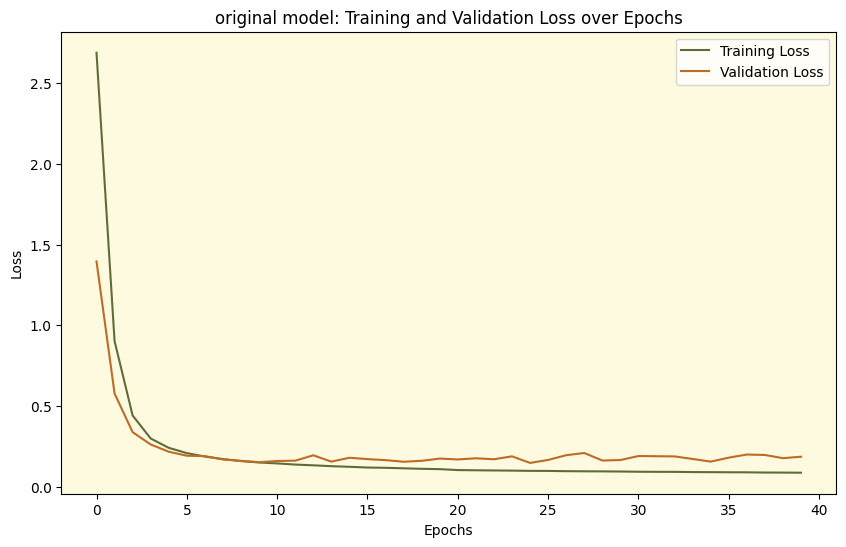

In [7]:
og_model.plot_training_history(save="original")

18/18 [==============================] - 0s 3ms/step
Training RMSE: 4.1251134888322945
Validation RMSE: 5.288399811225908 

Training MAE: 3.098438168945529
Validation MAE: 4.154498167719161 

Training R²: 0.8447340163233008
Validation R²: 0.6837852689686691


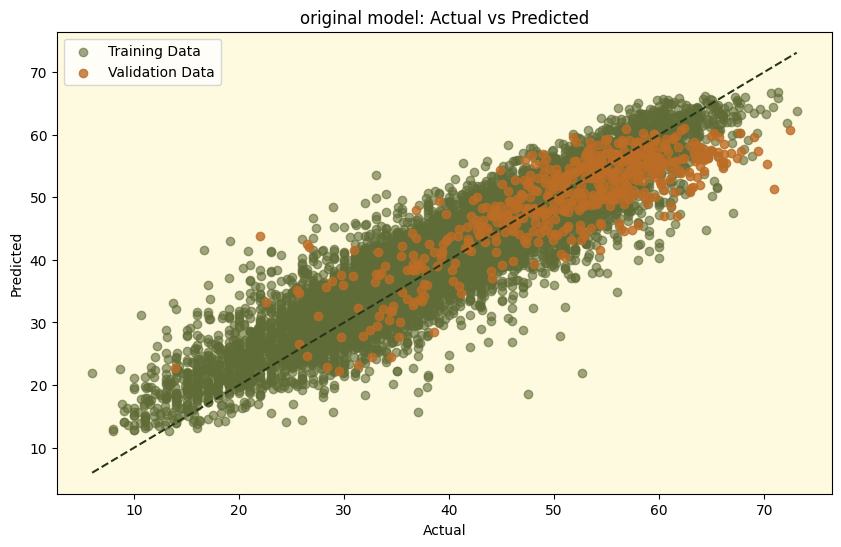

In [8]:
og_evaluator = EvaluateModel(og_model, X_train, y_train, X_val, y_val, M[0,0], S[0,0])
og_evaluator.evaluate(save="original")

### 3.2. Standard Attention Model

Now we will train the exact same model with an additional attention layer inside the W-CNN. The idea is that this attention layer is able to guide the models focus on the most important weeks for each data attribute over the different plant growth stages.

In [9]:
standard_att_model = AttModel(learning_rate, time_steps, num_units, num_layers, dropout, num_heads, key_dim, multi_head=False)
standard_att_model.compile()


--- Model Architecture ---
 - CNN for Weather data - 
Input W-CNN: 6x (None, 52, 1)
Output W-CNN: (None, 66)
 - CNN for Soil data - 
Input S-CNN: 11x (None, 6, 1)
Output S-CNN: (None, 44)
 - Concatenate weather, soil and management data - 
W+S+M concatenated: (None, 124)
W+S+M after Dense: (None, 64)
 - LSTM for yield data - 
LSTM input: (None, 5, 1)
LSTM output: (None, 16)
 - Combine static and dynamic features - 
Combined: (None, 80)
Combined Dense: (None, 16)
Output: (None, 1) 

Total parameters: 36483


In [10]:
standard_att_model.fit_wrapper(X_train, y_train, X_val, y_val, epochs)

Epoch 1/80
441/441 [==============================] - 17s 19ms/step - loss: 2.6417 - val_loss: 1.3525 - lr: 2.0000e-04
Epoch 2/80
441/441 [==============================] - 6s 14ms/step - loss: 0.8592 - val_loss: 0.5471 - lr: 2.0000e-04
Epoch 3/80
441/441 [==============================] - 7s 17ms/step - loss: 0.4260 - val_loss: 0.3372 - lr: 2.0000e-04
Epoch 4/80
441/441 [==============================] - 7s 16ms/step - loss: 0.2949 - val_loss: 0.2819 - lr: 2.0000e-04
Epoch 5/80
441/441 [==============================] - 6s 14ms/step - loss: 0.2427 - val_loss: 0.2536 - lr: 2.0000e-04
Epoch 6/80
441/441 [==============================] - 7s 15ms/step - loss: 0.2128 - val_loss: 0.1915 - lr: 2.0000e-04
Epoch 7/80
441/441 [==============================] - 7s 15ms/step - loss: 0.1929 - val_loss: 0.2132 - lr: 2.0000e-04
Epoch 8/80
441/441 [==============================] - 7s 15ms/step - loss: 0.1782 - val_loss: 0.1663 - lr: 2.0000e-04
Epoch 9/80
441/441 [==============================] - 7

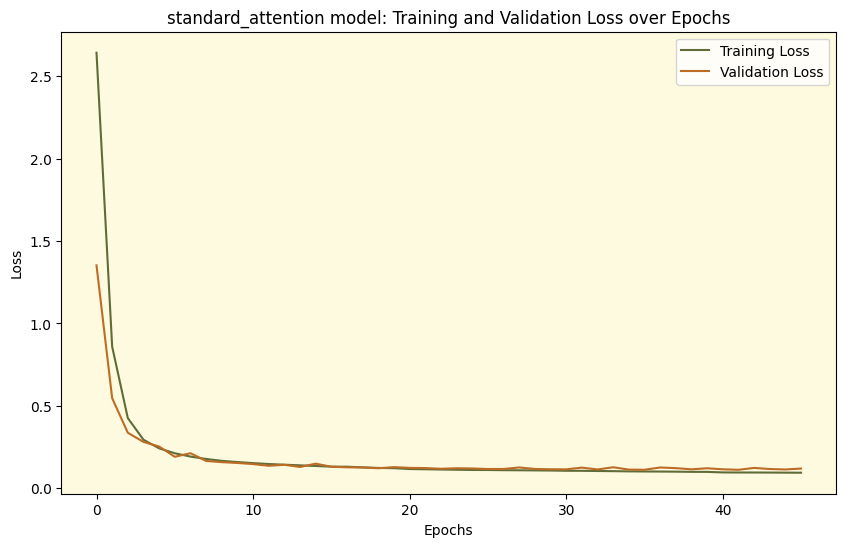

In [11]:
standard_att_model.plot_training_history(save="standard_attention")

18/18 [==============================] - 0s 5ms/step
Training RMSE: 4.242945312976572
Validation RMSE: 4.610481615346718 

Training MAE: 3.177693972795641
Validation MAE: 3.585748967443194 

Training R²: 0.8357371381250065
Validation R²: 0.7596599623031837


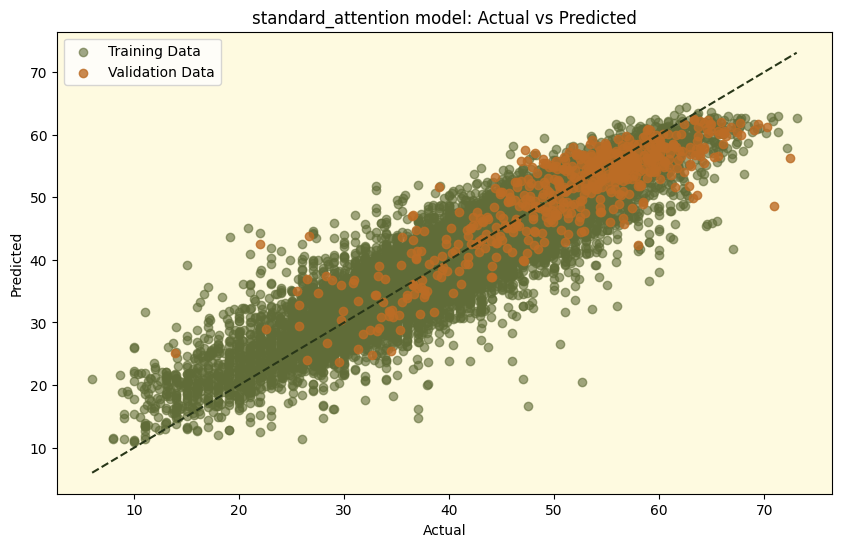

In [12]:
standard_att_evaluator = EvaluateModel(standard_att_model, X_train, y_train, X_val, y_val, M[0,0], S[0,0])
standard_att_evaluator.evaluate(save="standard_attention")

### 3.3. Multi-Head Attention Model

We will also try to further enhance this with an additional multi-head-attention layer placed right after the W-CNN. 
This means it gets information from all weather attributes combined. The idea is that the previously implemented attention layers focus on the timely component of each individually attribute and this multi-head-attention layer focuses on the most important information across all weather input data.

In [13]:
multihead_att_model = AttModel(learning_rate, time_steps, num_units, num_layers, dropout, num_heads, key_dim, multi_head=True)
multihead_att_model.compile()


--- Model Architecture ---
 - CNN for Weather data - 
Input W-CNN: 6x (None, 52, 1)
Output W-CNN: (None, 66)
 - Multi-Head Attention for Weather data - 
Output W-Attention: (None, 66)
 - CNN for Soil data - 
Input S-CNN: 11x (None, 6, 1)
Output S-CNN: (None, 44)
 - Concatenate weather, soil and management data - 
W+S+M concatenated: (None, 124)
W+S+M after Dense: (None, 64)
 - LSTM for yield data - 
LSTM input: (None, 5, 1)
LSTM output: (None, 16)
 - Combine static and dynamic features - 
Combined: (None, 80)
Combined Dense: (None, 16)
Output: (None, 1) 

Total parameters: 37380


In [14]:
multihead_att_history, multihead_att_weights = multihead_att_model.fit_wrapper(X_train, y_train, X_val, y_val, epochs)

Epoch 1/80
441/441 [==============================] - 19s 21ms/step - loss: 2.7058 - val_loss: 1.4213 - lr: 2.0000e-04
Epoch 2/80
441/441 [==============================] - 8s 18ms/step - loss: 0.9179 - val_loss: 0.5983 - lr: 2.0000e-04
Epoch 3/80
441/441 [==============================] - 8s 17ms/step - loss: 0.4581 - val_loss: 0.3717 - lr: 2.0000e-04
Epoch 4/80
441/441 [==============================] - 8s 19ms/step - loss: 0.3118 - val_loss: 0.3111 - lr: 2.0000e-04
Epoch 5/80
441/441 [==============================] - 9s 19ms/step - loss: 0.2524 - val_loss: 0.2741 - lr: 2.0000e-04
Epoch 6/80
441/441 [==============================] - 8s 19ms/step - loss: 0.2198 - val_loss: 0.2269 - lr: 2.0000e-04
Epoch 7/80
441/441 [==============================] - 8s 19ms/step - loss: 0.1997 - val_loss: 0.2510 - lr: 2.0000e-04
Epoch 8/80
441/441 [==============================] - 8s 19ms/step - loss: 0.1831 - val_loss: 0.2119 - lr: 2.0000e-04
Epoch 9/80
441/441 [==============================] - 8

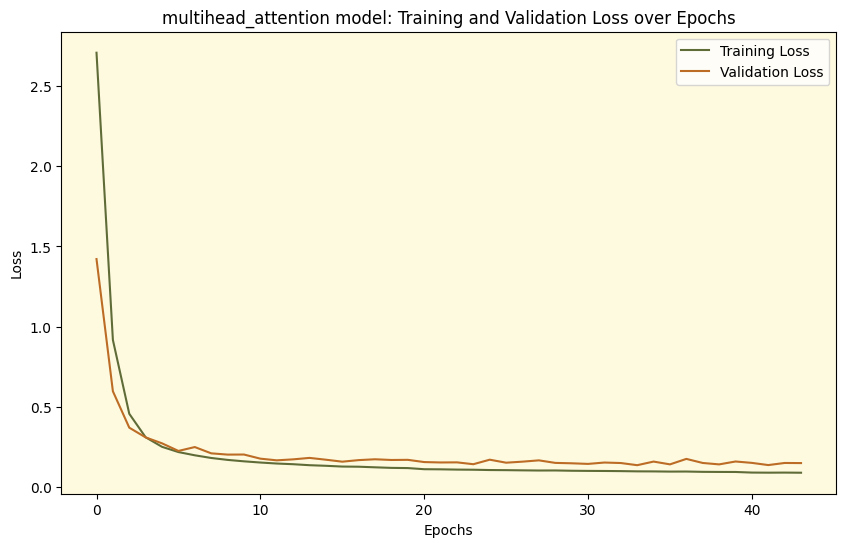

In [15]:
multihead_att_model.plot_training_history(save="multihead_attention")

18/18 [==============================] - 0s 10ms/step
Training RMSE: 4.297378686825432
Validation RMSE: 5.190594511479087 

Training MAE: 3.2083133039850003
Validation MAE: 3.9836386224201745 

Training R²: 0.8314953974181787
Validation R²: 0.6953734568871591


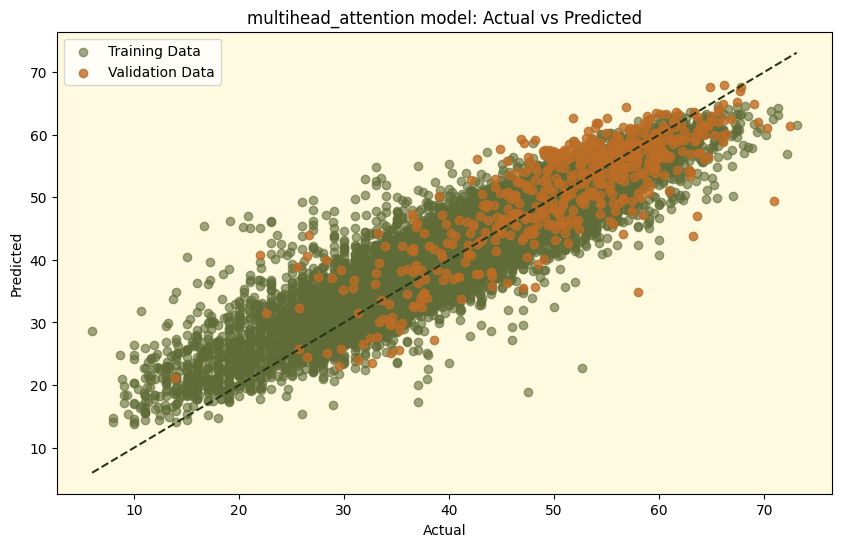

In [16]:
multihead_att_evaluator = EvaluateModel(multihead_att_model, X_train, y_train, X_val, y_val, M[0,0], S[0,0])
multihead_att_evaluator.evaluate(save="multihead_attention")

In [17]:
og_model.model.save('../models/og_model.keras')
standard_att_model.model.save('../models/standard_att_model.keras')
multihead_att_model.model.save('../models/multihead_att_model.keras')

### 4. Explainability

Finally, we introduce an explainability method called "LIME". The abbreviation stands for Local Interpretable Model-agnostic Explanations. It is a powerful tool used to explain the predictions of machine learning model by approximating the model locally with an interpretable one. LIME helps to understand the influence of individual features on specific predictions.

One of its applications is in comparing feature importance before and after making changes to a model's architecture. By using LIME, you can track how the importance of different features shifts as you modify your model, providing valuable insights into the impact of these changes. This makes LIME an essential tool for model evaluation and refinement.

In [18]:
og_explainer = ExplainModel(og_model, X_train, M[:,1:], S[:,1:], time_steps)

In [19]:
og_explainer.explain_observation(X_val, index = 10, top = 5, show_table=True)

157/157 [==============================] - 1s 5ms/step
Intercept 0.5802995608384766
Prediction_local [0.69681934]
Right: 1.7423445


[('max temp_29 > 0.65', 0.21993540834377664),
 ('M3 <= -0.57', 0.19242936198657282),
 ('max temp_32 <= -0.64', 0.18112661301645586),
 ('max temp_23 > 0.67', 0.17660370234543446),
 ('M2 > 0.49', 0.17115423441136918)]

In [20]:
indices = [i+30 for i in range(15)]
og_explainer.explain_many_observations(X_val, indices, top = 30)
og_feature_importance = og_explainer.get_feature_importance_table("original")

att_explainer = ExplainModel(standard_att_model, X_train, M[:,1:], S[:,1:], time_steps)
att_explainer.explain_many_observations(X_val, indices, top = 30)
att_feature_importance = att_explainer.get_feature_importance_table("attention")

157/157 [==============================] - 1s 5ms/step
Intercept 0.8298572651374259
Prediction_local [1.18629211]
Right: 1.561603
157/157 [==============================] - 1s 5ms/step
Intercept 1.0831755932192075
Prediction_local [1.47699489]
Right: 1.6709353
157/157 [==============================] - 1s 5ms/step
Intercept 0.9348066985254577
Prediction_local [1.36683538]
Right: 1.8982141
157/157 [==============================] - 1s 4ms/step
Intercept 1.4809817105805465
Prediction_local [1.49909296]
Right: 1.7374959
157/157 [==============================] - 1s 4ms/step
Intercept 1.75955480092203
Prediction_local [0.94130234]
Right: 0.8119039
157/157 [==============================] - 1s 5ms/step
Intercept 1.8727260973871067
Prediction_local [1.49395473]
Right: 1.1051476
157/157 [==============================] - 1s 5ms/step
Intercept 0.5498721484050197
Prediction_local [0.8997411]
Right: 0.649367
157/157 [==============================] - 1s 5ms/step
Intercept 1.1982871329780242
Pred

LIME expresses the importance of features in units of the predictor variable. However, you cannot directly compare them for different attributes as they do not add up to the same value, especially when only the top X number of features are evaluated. Therefore, to make the values comparable, the impact is shown below as a percentage of the total per model.

This means that the bars below always add up to 1.

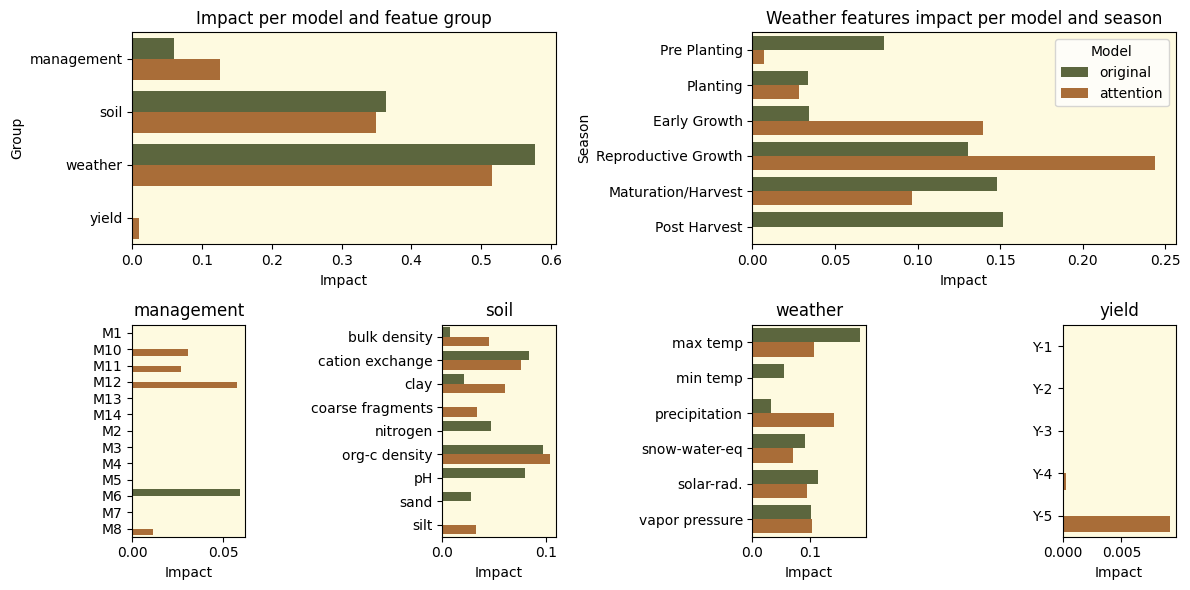

In [21]:
compare_feature_impact(og_feature_importance, att_feature_importance)